In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
import cv2
from PIL import Image

%load_ext autoreload
%autoreload 2

In [97]:
import sys
sys.path.append('../')
sys.path.append('../core')

from raft import RAFT
from train import get_args, load_model, IsMovingTarget
import datasets as raft_datasets
import utils.flow_viz as flow_viz

def set_args(args_dict={}):
    args = get_args("")
    for k,v in args_dict.items():
        args.__setattr__(k, v)
    return args

def tensor_to_arr(tensor, ex=0):
    if len(tensor.shape) == 4:
        tensor = tensor[ex]
    return tensor.detach().permute(1, 2, 0).cpu().numpy()

def viz(tensor, ex=0):
    im = tensor_to_arr(tensor, ex)
    if im.max() > 2.0:
        im = im / 255.0
    plt.imshow(im)
    

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Flows are coded as (x, y) where +y is upward in the image; value is in pixels

In [68]:
!ls ../checkpoints/raft-tdw-bn*
# !ls ../models/*

../checkpoints/raft-tdw-bn-0wd.pth
../checkpoints/raft-tdw-bn-100clip.pth
../checkpoints/raft-tdw-bn-10iters.pth
../checkpoints/raft-tdw-bn-2iters.pth
../checkpoints/raft-tdw-bn-3iters.pth
../checkpoints/raft-tdw-bn-4iters.pth
../checkpoints/raft-tdw-bn-5iters.pth
../checkpoints/raft-tdw-bn-6iters.pth
../checkpoints/raft-tdw-bn-8iters.pth
../checkpoints/raft-tdw-bn-allframes.pth
../checkpoints/raft-tdw-bn-amaxflowframes.pth
../checkpoints/raft-tdw-bn-amaxtotalenergyframes.pth
../checkpoints/raft-tdw-bn-fullplay.pth
../checkpoints/raft-tdw-bn.pth


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
act_net = load_model('../checkpoints/occlusion-tdw-bs8-small-20frames-fullplay-tr0-8.pth',
                 train=False, cuda=True, freeze_bn=False, small=True, gpus=[0])
# net = load_model('../checkpoints/raft-tdw-bn-fullplay.pth',
#                  train=False, cuda=True, freeze_bn=False, gpus=[0])


<All keys matched successfully> ThingsClassifier


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [82]:
raft_load_path = 'raft-sintel.pth'
raft_net = load_model(os.path.join('../models/', raft_load_path),
                 train=False, cuda=True, freeze_bn=False, small=False, gpus=[0])

# raft_load_path = 'raft-tdw-bn-fullplay.pth'
# raft_net = load_model(os.path.join('../checkpoints/', raft_load_path),
#                  train=False, cuda=True, freeze_bn=False, small=False, gpus=[0])

<All keys matched successfully> RAFT


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [95]:
motion_load_path = '35000_motion-rnd0-tdw-bs8-small-fullplay-tr0-8.pth'
motion_net = load_model(os.path.join('../checkpoints/', motion_load_path),
                 train=False, cuda=True, freeze_bn=False, small=True, gpus=[0])

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<All keys matched successfully> MotionClassifier


In [10]:
cent_net = load_model('../checkpoints/20000_mocentroid-tdw-bs8-fullplay-tr0-8.pth', 
                     small=False, train=False, cuda=True, freeze_bn=True, gpus=[0])

<All keys matched successfully> CentroidRegressor


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [100]:
tdw_dataset = raft_datasets.TdwFlowDataset(
    root='/data5/dbear/tdw_datasets/playroom_large_v3copy/',
#     root='/mnt/fs5/dbear/tdw_datasets/primitives_large_v1/',
#     root='/mnt/fs5/dbear/tdw_datasets/playroom_large_v3/',
    dataset_names=['model_split_4'],    
#     dataset_names=['model_split_%d' % split for split in range(4)],
    split='training',
    filepattern="*",
#     test_filepattern="0*[0-4]",
    test_filepattern="*9",
    min_start_frame=6,
    max_start_frame=6,
    scale_to_pixels=True,
    get_gt_flow=True,
    get_backward_frame=True
)
print(len(tdw_dataset))
print(tdw_dataset.is_test)

1250
False


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [98]:
import time 

def viz_raft_prediction(model, dataset, ex=0, iters=[1,12,24], thingness=False, 
                        centroid=False, thresh=None, time_it=False):
    dataset.is_test = False
    dataset.get_backward_frame = False
    if ex is None:
        ex = np.random.randint(0, len(dataset))
    try:
        img1, img2, gt, _ = dataset[ex]
    except:
        img1, img2 = dataset[ex][:2]
        gt = None
    dataset.get_backward_frame = True
    preds = []
    if not isinstance(iters, list):
        iters = [iters]
    for it in iters:
        s = time.time()
        _, pred = model(img1[None].cuda(), img2[None].cuda(), iters=it, test_mode=True)
        e = time.time()
        if time_it:
            print("%0.3f seconds for %d iters" % (e - s, it)) 
        if thingness:
            pred = torch.sigmoid(pred)[0,0].detach().cpu().numpy()
            if thresh is not None:
                pred = (pred > thresh)
        elif centroid:
            pass
        else:
            if thresh is None:
                pred = flow_viz.flow_to_image(tensor_to_arr(pred))
            else:
                pred = pred.square().sum(-3, True).sqrt()[0,0].detach().cpu().numpy()
                pred = (pred > thresh)
        preds.append(pred)
    if gt is not None:
        _flow_gt = flow_viz.flow_to_image(tensor_to_arr(gt))

    fig, axes = plt.subplots(
        1,1 + len(iters) + int(gt is not None), figsize=(4 + 4*int(gt is not None) + 4*len(iters),4))
    axes[0].imshow(img1.permute(1, 2, 0).numpy() / 255.)
    for i in range(len(iters)):
        axes[1+i].imshow(preds[i])
    if gt is not None:
        axes[-1].imshow(_flow_gt)
    
    titles = ['img1'] + ['pred @ %d iters' % it for it in iters] + (['gt'] if gt is not None else [])
    
    for i, ax in enumerate(axes):
        ax.set_title(titles[i], fontsize=18)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()  

    
# def viz_h0_prediction(thingness_model, centroid_model, dataset, ex=0, iters=[1,6,12], thresh=None):
#     pass



/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


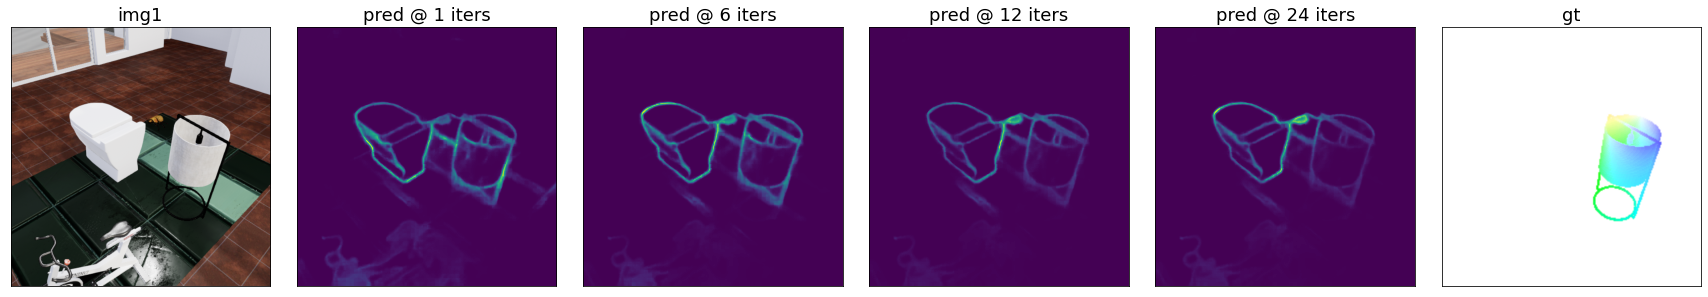

In [14]:
# ex = 41
# viz_raft_prediction(act_net, tdw_dataset, ex=ex, iters=[1,6,12,24], thingness=True, thresh=None)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


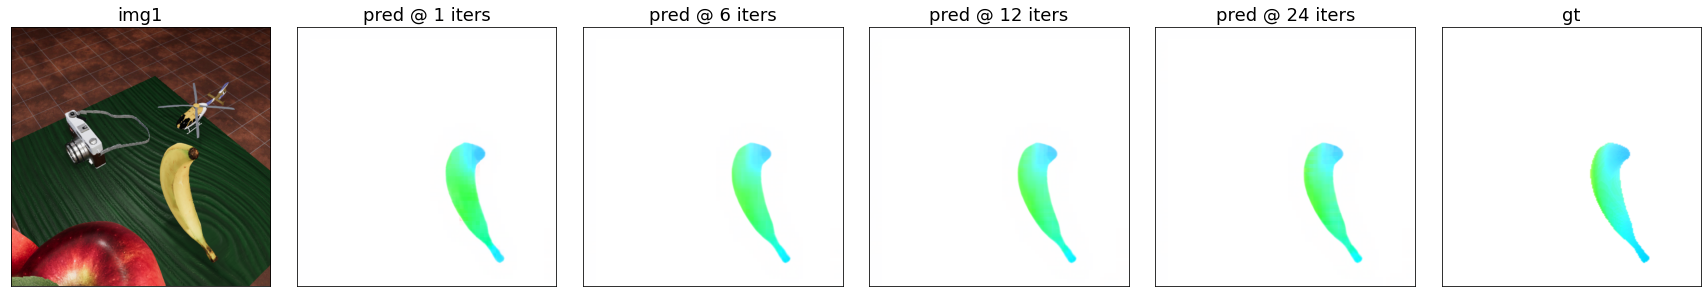

In [70]:
ex = 41
viz_raft_prediction(raft_net, tdw_dataset, ex=ex, iters=[1,6,12,24], thingness=False, thresh=None)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


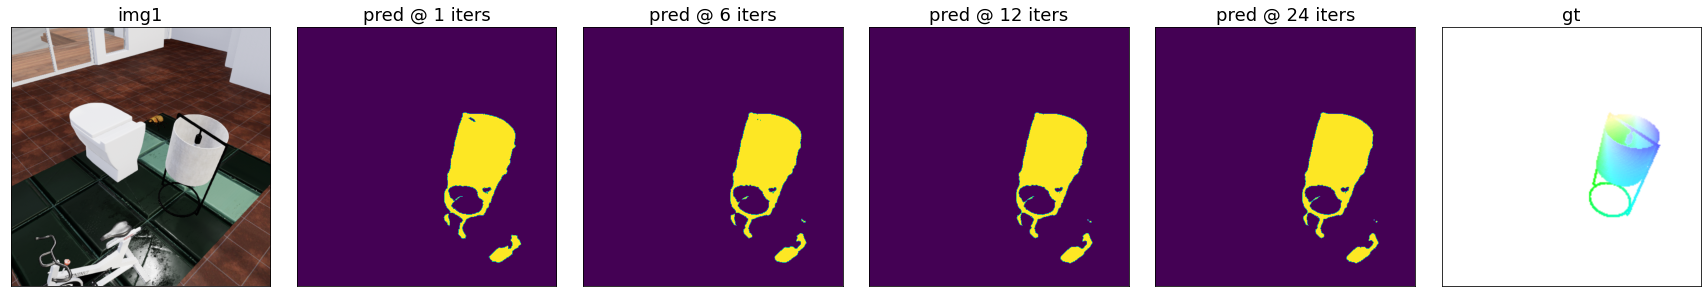

In [102]:
ex = 41
viz_raft_prediction(motion_net, tdw_dataset, ex=ex, iters=[1,6,12,24], thingness=True, thresh=0.1)

## Look at the motion target

In [22]:
img1, img2, img0, _ = tdw_dataset[ex]
print(img1.shape, img2.shape, img0.shape)

torch.Size([3, 512, 512]) torch.Size([3, 512, 512]) torch.Size([3, 512, 512])


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
IM = IsMovingTarget(thresh=None, warp_radius=3).cuda()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [94]:
from collections import OrderedDict
ex = 11
thresh = None
IM.thresh = None
iters = 1

img1, img2, img0, _ = tdw_dataset[ex]
video = torch.stack([img1, img2], 0) / 255.
_, cfeats1 = cent_net(img1[None].cuda(), img1[None].cuda(), test_mode=True, iters=iters)
_, cfeats2 = cent_net(img2[None].cuda(), img2[None].cuda(), test_mode=True, iters=iters)
cfeats = torch.cat([cfeats1, cfeats2], 0)
_, motion = motion_net(img1[None].cuda(), img2[None].cuda(), test_mode=True, iters=iters)
motion = (torch.sigmoid(motion) > thresh).float() if thresh is not None else torch.sigmoid(motion)
# video = torch.cat([video, cfeats.to(video.device)], -3)
# video = cfeats

targets = OrderedDict()
targets['rgb'] = IM(video[None].cuda())
targets['centroid'] = IM((motion * cfeats)[None].cuda())
targets['motion'] = motion[None]
# targets['rgb_centroid'] = IM((motion.to(video.device) * torch.cat([video, cfeats.to(video.device)], -3))[None])
targets['delta_images'] = (video[0:1] - video[1:2]).abs().sum(-3, True)[None] > 0.02

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


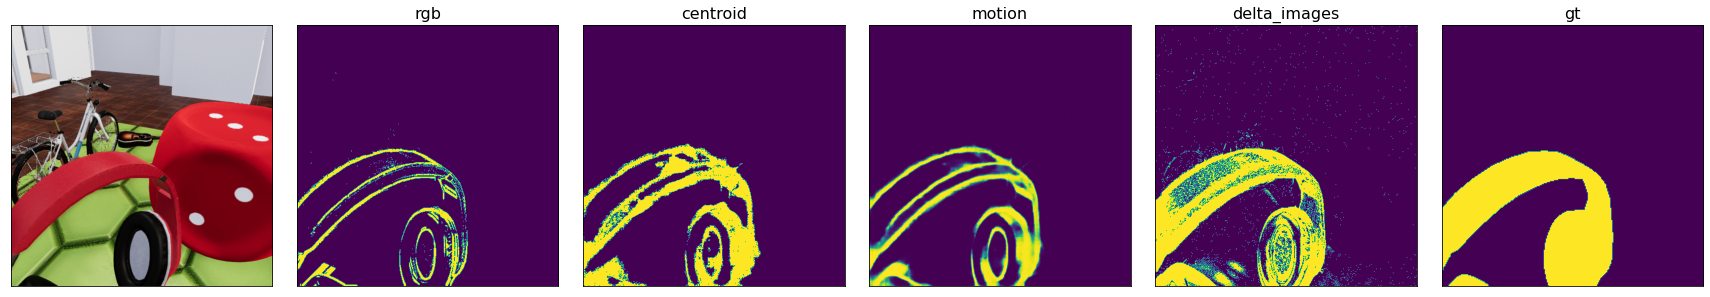

In [95]:
fig, axes = plt.subplots(1, 2 + len(targets.keys()), figsize=(8 + 4*len(targets.keys()), 4))
_np = lambda t: t.detach().cpu().numpy()[0,0,0]
axes[0].imshow(img1.permute(1,2,0).numpy() / 255.)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[-1].imshow((gt.abs().sum(0) > 0.5).cpu().numpy())
axes[-1].set_xticks([])
axes[-1].set_yticks([])
axes[-1].set_title('gt', fontsize=16)
keys = list(targets.keys())
for i,ax in enumerate(axes[1:-1]):
    ax.imshow(_np(targets[keys[i]]))
    ax.set_title(keys[i], fontsize=16)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

In [7]:
import bootraft
import dorsalventral.models.segmentation.competition as competition
kpnet = bootraft.KpPrior(
    net, act_net, normalize_coordinates=True, randomize_background=True, resolution=6, 
    thingness_thresh=0.1, norm_p=2.0
).cuda()
comp = competition.Competition(num_masks=32, num_competition_rounds=3, compete_thresh=0.2).cuda()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
val_dataset = raft_datasets.TdwAffinityDataset(training=False, mean=None, std=None,
                                          raft_ckpt=None, 
                                          single_supervision=False,
#                                           test_splits="4",
#                                           test_filepattern="0*[0-4]",
                                          full_supervision=True,
                                          is_test=True)
print(len(val_dataset))

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


500


In [103]:
motion_load_path = '10000_motion-rnd0-tdw-bs8-small-fullplay-tr0-8.pth'
motion_net = load_model(os.path.join('../checkpoints/', motion_load_path),
                 train=False, cuda=True, freeze_bn=False, small=True, gpus=[0])

<All keys matched successfully> MotionClassifier


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


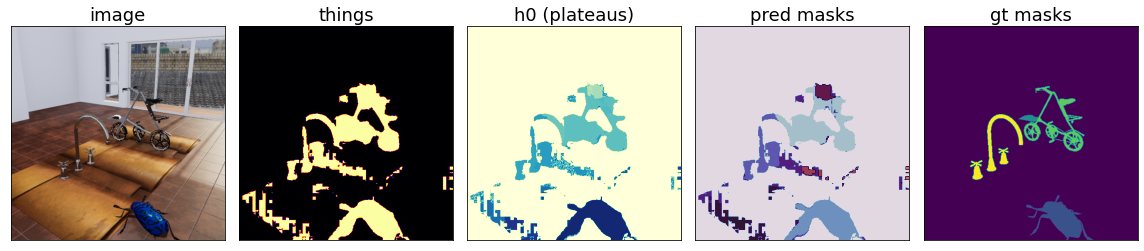

In [94]:
import dorsalventral.trainval.segmentation_metrics as metrics

def get_h0_segments(image, prior_model, mask_model, competition_model, iters=12, thresh=None):
    _thresh = prior_model.thingness_thresh
    if thresh is not None:
        prior_model.thingness_thresh = thresh
    h = prior_model(image[None].cuda(), image[None].cuda(), test_mode=True)
    _, thing = mask_model(image.cuda()[None], image.cuda()[None], iters=iters, test_mode=True)
    m = (torch.sigmoid(thing) > prior_model.thingness_thresh)[:,0,...,None].float()
    h = h.permute(0,2,3,1)
    h = torch.cat([1-m, h*m], -1) 
    masks = competition_model(h)[0]
    
    ## postprocess masks for visualization
    labels = torch.unique(masks.argmax(-1))
    masks = (labels.view(1,1,1,-1) == masks.argmax(-1)[...,None]).float()    
    areas = masks.sum(dim=(1,2))[0]
    k_inds = torch.argsort(areas, descending=True)
    masks = masks[0].permute(2,0,1)[k_inds,:,:].permute(1,2,0)[None]
    
    prior_model.thingness_thresh = _thresh
    
    return (h, masks)

def viz_h0_segments(dataset, ex, prior_model, mask_model, competition_model, iters=12, thresh=None, do_plot=True):
    img, gt, _ = dataset[ex]
    h0, masks = get_h0_segments(img, prior_model, mask_model, competition_model, iters=iters, thresh=thresh)
    
    if do_plot:
        
        fig, axes = plt.subplots(1,5,figsize=(16,4))
        titles = ['image', 'things', 'h0 (plateaus)', 'pred masks', 'gt masks']
        cmaps = [None, 'inferno', 'YlGnBu', 'twilight', 'viridis']
        plots = {
            0: tensor_to_arr(img / 255.),
            1: tensor_to_arr(h0.argmax(-1) != 0),
            2: tensor_to_arr(h0.argmax(-1)),
            3: tensor_to_arr(masks.argmax(-1)),
            4: tensor_to_arr(gt[None])
        }
        for i, ax in enumerate(axes):
            p = plots[i]
            if i == 3:
                ax.imshow(p, cmap=cmaps[i], vmax=masks.shape[-1]+1)
            else:
                ax.imshow(p, cmap=cmaps[i])
            ax.set_title(titles[i], fontsize=18)
            ax.set_xticks([])
            ax.set_yticks([])
        plt.tight_layout()
        plt.show()    
        
    return (masks.argmax(-1), gt[None])

def get_ious(dataset, examples, *args, **kwargs):
    
    if examples is None:
        examples = range(len(dataset))
    elif isinstance(examples, int):
        examples = [examples]
    
    best_ious, mean_ious = [], []
    for ex in tqdm(examples):
        pred, gt = viz_h0_segments(dataset, ex, do_plot=False, *args, **kwargs)
        M = metrics.SegmentationMetrics(
            gt_objects=gt.to(torch.int32),
            pred_objects=pred.to(torch.int32).cpu()
        )
        M.compute_matched_IoUs(exclude_gt_ids=[0])
        best_ious.append(M.best_ious)
#         print(ex, best_ious[ex])
        mean_ious.append(M.mean_ious)

    mean_ious = np.array(mean_ious)
    grand_mean = np.nanmean(mean_ious)
    return (grand_mean, mean_ious, best_ious)

# h0, preds = get_h0_segments(val_dataset[3][0], kpnet, act_net, comp)
# print(h0.shape, preds.shape)    
pred, gt = viz_h0_segments(val_dataset, 2, kpnet, act_net, comp, thresh=0.1)
# get_ious(val_dataset, range(3), kpnet, act_net, comp)

In [62]:
# val_result, val_per_example, val_best_ious = get_ious(
#     val_dataset, None, kpnet, act_net, comp
# )

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 500/500 [03:47<00:00,  2.20it/s]


In [66]:
val_result, val_per_example[:10]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0.6559045403050233,
 array([[0.56390242],
        [0.70521843],
        [0.71922982],
        [0.69148245],
        [0.674486  ],
        [0.61928309],
        [0.53161622],
        [0.71787196],
        [0.60640213],
        [0.69849178]]))

In [76]:
# trainval_result, trainval_per_example, trainval_best_ious = get_ious(
#     val_dataset, None, kpnet, act_net, comp
# )

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 490/490 [03:41<00:00,  2.21it/s]


In [77]:
trainval_result

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.6143716833231574

In [91]:
## crossvalidate thingness thresh
threshs = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25]
t_results = dict()
for t in threshs:
    t_trainval_result, trainval_per_example, trainval_best_ious = get_ious(
        val_dataset, None, kpnet, act_net, comp, thresh=t
    )
    t_results[t] = t_trainval_result
    print("thresh: %.3f" % t, t_trainval_result)
for t in threshs:
    print(t, t_results[t])

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/490 [00:00<?, ?it/s]

thresh: 0.010 0.5619349818167043


  0%|          | 0/490 [00:00<?, ?it/s]

thresh: 0.050 0.6162255179201357


  0%|          | 0/490 [00:00<?, ?it/s]

thresh: 0.100 0.6136601587130216


  0%|          | 0/490 [00:00<?, ?it/s]

thresh: 0.150 0.5556069436033607


  0%|          | 0/490 [00:00<?, ?it/s]

thresh: 0.200 0.42587540607213326


100%|██████████| 490/490 [03:42<00:00,  2.20it/s]

thresh: 0.250 0.30343433720913765
0.01 0.5619349818167043
0.05 0.6162255179201357
0.1 0.6136601587130216
0.15 0.5556069436033607
0.2 0.42587540607213326
0.25 0.30343433720913765


torch.Size([2, 512, 512, 3])
(2, 512, 512, 1)
uint8


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


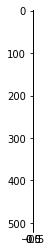

In [69]:
ex = 0
import dorsalventral.data.utils as data_utils
import dorsalventral.vis_utils as vis_utils
tdw_dataset.get_backward_frame = False
fc = data_utils.FillContours(to_float=True, channels_last=False)
delta = data_utils.DeltaImages(thresh=0.01, channels_last=True)
img1, img2 = [x.permute(1,2,0) for x in tdw_dataset[ex][:2]]
ims = torch.stack([img2, img1], 0) / 255.

print(ims.shape)
delta_ims = delta(ims.cpu().numpy())
print(delta_ims.shape)
delta_ims = delta_ims[1:,0,:,:,None]
contours = fc(delta_ims)
vis_utils.imshow(torch.tensor(contours))

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(1, 512, 512, 1)


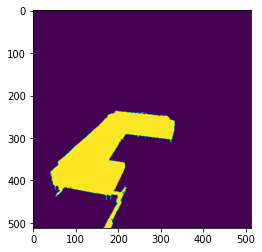

In [83]:
FDI = data_utils.FillDeltaImagesRaft(thresh=0.01)
_, result = FDI(*[x[None].cuda() for x in tdw_dataset[ex][:2]])
vis_utils.imshow(result)

## Evaluating quality of motion segment on TDW

In [104]:
motion_load_path = '35000_motion-rnd0-tdw-bs8-small-fullplay-tr0-8.pth'
motion_net = load_model(os.path.join('../checkpoints/', motion_load_path),
                 train=False, cuda=True, freeze_bn=False, small=True, gpus=[0])

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<All keys matched successfully> MotionClassifier


In [92]:
# motion_load_path = 'motion-rnd0-tdw-bs8-large-fullplay-tr0-8.pth'
# motion_net = load_model(os.path.join('../checkpoints/', motion_load_path),
#                  train=False, cuda=True, freeze_bn=False, small=False, gpus=[0])

<All keys matched successfully> MotionClassifier


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [105]:
tdw_dataset = raft_datasets.TdwFlowDataset(
#     root='/data5/dbear/tdw_datasets/playroom_large_v3copy/',
#     root='/mnt/fs5/dbear/tdw_datasets/primitives_large_v1/',
    root='/mnt/fs5/dbear/tdw_datasets/playroom_large_v3/',
#     dataset_names=['model_split_4'],    
    dataset_names=['model_split_%d' % split for split in range(4)],
    split='validation',
#     filepattern="*[0-8]",
#     test_filepattern="0*[0-4]",
    test_filepattern="*9",
    min_start_frame=6,
    max_start_frame=6,
    scale_to_pixels=True,
    get_gt_flow=True,
    get_backward_frame=False
)
print(len(tdw_dataset))
print(tdw_dataset.is_test)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


500
True


In [106]:
from tqdm import tqdm
DEFAULT_CMAP = plt.cm.twilight
DEFAULT_ERRMAP_COLORS = {k:float(v)/DEFAULT_CMAP.N for k,v in {'tp': 250, 'tn': 0, 'fp': 420, 'fn': 80}.items()}

def plot_errormap(model, dataset, ex=None, iters=24, thresh=4, 
                  cmap=DEFAULT_CMAP,
                  colors=DEFAULT_ERRMAP_COLORS,
                  do_plot=True,
                  return_errormap=True,
                  return_images=False,
                  thingness=False
                 ):
    if ex is None:
        ex = np.random.randint(len(dataset))
        
    blob = dataset[ex]
    try:
        img1, img2, flow = blob[:3]
    except:
        img1, img2 = blob[:2]
        flow = torch.zeros_like(img1[:2])
    _, pred = model(img1[None].cuda(), img2[None].cuda(), iters=iters, test_mode=True)
    
    if thingness:
        _seg = lambda x, t: (torch.sigmoid(x) > t).cpu().numpy()[0,0]
    else:
        _seg = lambda x, t: (x.square().sum(-3).sqrt() > t).cpu().numpy()[0]
    pred_seg = _seg(pred, thresh)
    gt_seg = (flow.square().sum(-3).sqrt() > 0.5).cpu().numpy()
#     gt_seg = _seg(flow[None], 0.5)
    
    tp = pred_seg & gt_seg
    tn = ~pred_seg & ~gt_seg
    fp = pred_seg & ~gt_seg
    fn = ~pred_seg & gt_seg
    n = (pred_seg | gt_seg).sum() + 0.
    
    metrics = {
        'iou': tp.sum() / n,
        'precision': (tp.sum() + 0.) / (tp.sum() + fp.sum()),
        'recall': (tp.sum() + 0.) / (tp.sum() + fn.sum())
    }

    errmap = np.zeros(list(gt_seg.shape) + [3])
    errmap[pred_seg & gt_seg] = list(cmap(colors['tp']))[:3]
    errmap[~pred_seg & ~gt_seg] = list(cmap(colors['tn']))[:3]
    errmap[pred_seg & ~gt_seg] = list(cmap(colors['fp']))[:3]
    errmap[~pred_seg & gt_seg] = list(cmap(colors['fn']))[:3]
    
    if do_plot:
        plt.imshow(errmap)
        plt.xticks([])
        plt.yticks([])
        plt.show()
    elif return_errormap:
        metrics['error_map'] = errmap
        
    if return_images:
        metrics.update({
            'image1': img1.permute(1, 2, 0).cpu().numpy() / 255.,
            'image2': img2.permute(1, 2, 0).cpu().numpy() / 255.,
            'pred': flow_viz.flow_to_image(tensor_to_arr(pred[0])) if not thingness else tensor_to_arr(torch.sigmoid(pred[0])),
            'gt': flow_viz.flow_to_image(tensor_to_arr(flow)) if not thingness else gt_seg
        })
    
    return metrics

def visualize_error_maps(model, dataset, examples=[0], iters=24, thresh=4, max_examples=5, thingness=False):
    
    def val_fn(ex):
        metrics = plot_errormap(model, dataset, ex=ex, iters=iters, thresh=thresh, 
                                do_plot=False, return_errormap=True, return_images=True, thingness=thingness)
        return metrics
    
    if examples is None:
        examples = [np.random.randint(len(dataset)) for _ in range(max_examples)]
    elif isinstance(examples, int):
        examples = [examples]
    else:
        examples = examples[:max_examples]
        
    titles = ['img1', 'img2', 'gt', 'pred @ %d iters' % iters, 'iou = ']
    n_rows = min(len(examples), max_examples)
    n_cols = len(titles)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
    if n_rows == 1:
        axes = [axes]
    
    for row, ex in enumerate(examples):
        return_vals = val_fn(ex)
        ax = axes[row]
        ax[0].imshow(return_vals['image1'])
        ax[1].imshow(return_vals['image2'])
        ax[2].imshow(return_vals['gt'])
        ax[3].imshow(return_vals['pred'])
        ax[4].imshow(return_vals['error_map'])
        
        iou = return_vals['iou']
        ts = titles[:-1] + [titles[-1] + ("%.3f" % iou)]
        for col, title in enumerate(ts):
            if col == 4:
                ax[col].set_title(ts[col], fontsize=18, y=0.92)
            ax[col].set_xticks([])
            ax[col].set_yticks([])
        
    plt.tight_layout()
    plt.show()


def validate_examples(model, dataset, examples=[0], iters=24, thresh=4, thingness=False):
    
    def val_fn(ex):
        return plot_errormap(model, dataset, ex=ex, iters=iters, thresh=thresh, do_plot=False, 
                             return_errormap=False, thingness=thingness)
    
    if examples is None:
        examples = range(len(dataset))
    elif isinstance(examples, int):
        examples = [examples]
    
    metrics = {'iou': [], 'precision': [], 'recall': []}
    for ex in tqdm(examples):
        m = val_fn(ex)
        for k,v in m.items():
            metrics[k].append(v)
    return metrics

def agg_metrics(metrics):
    agg = {k:np.nanmean(np.array(v)) for k,v in metrics.items()}
    nans = {k+'_isnan':np.isnan(np.array(v)).mean() for k,v in metrics.items()}
    return (agg, nans)
    

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars


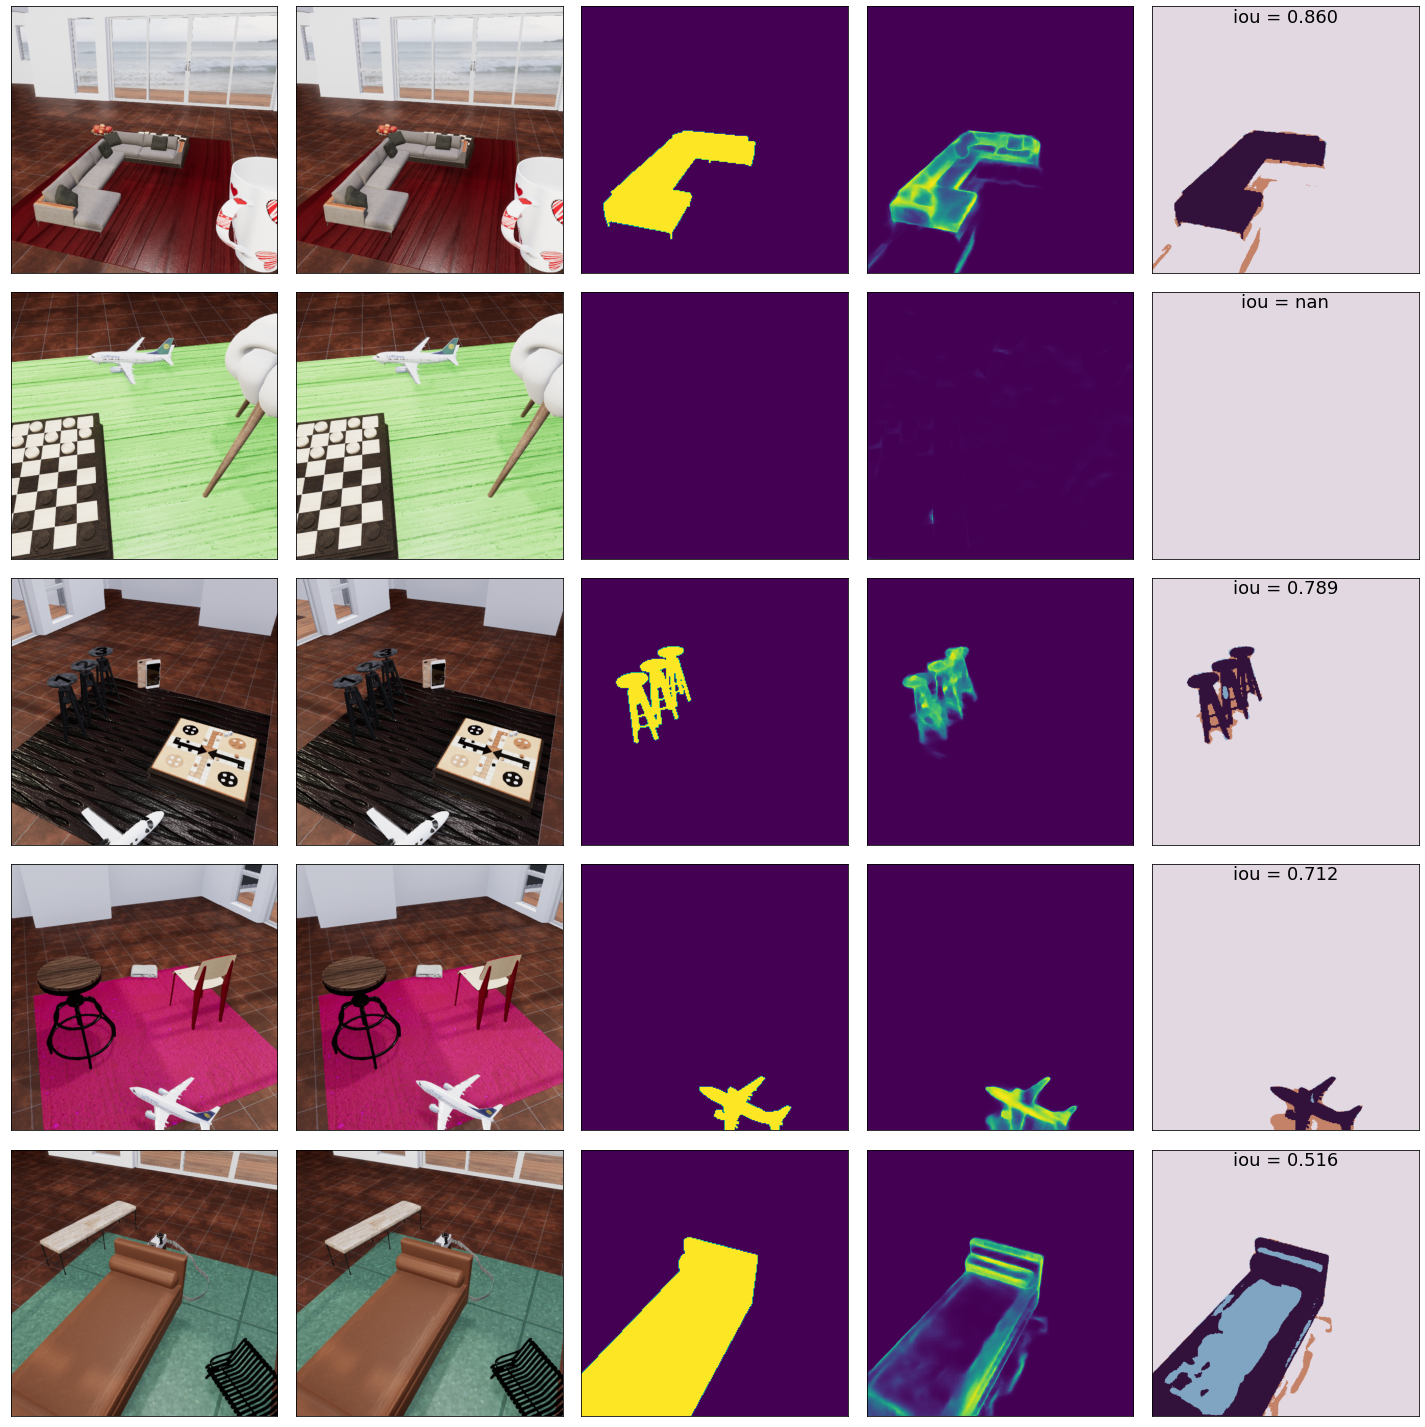

In [107]:
tdw_dataset.is_test = True
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5
examples = range(5)
# visualize_error_maps(raft_net, tdw_dataset, examples=examples, thresh=0.5, thingness=False, iters=24)
visualize_error_maps(motion_net, tdw_dataset, examples=examples, thresh=0.1, thingness=True, iters=24)
# visualize_error_maps(FDI, tdw_dataset, examples=examples, thresh=0.5, thingness=True, iters=24)

In [49]:
tdw_dataset.files[0]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'/mnt/fs5/dbear/tdw_datasets/playroom_large_v3/model_split_0/0009.hdf5'

In [91]:
tdw_dataset.test_mode = False
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5
examples = None
thresh = 0.5

print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
      ("filled delta images", tdw_dataset.test_mode, len(tdw_dataset), FDI.thresh))
metrics = validate_examples(FDI, tdw_dataset, examples=examples, thresh=thresh, iters=24, thingness=True)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 1/500 [00:00<01:00,  8.20it/s]

evaluating model --- filled delta images --- val = False, 500 at thresh = 0.01


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [03:06<00:00,  2.69it/s]


({'iou': 0.6290428769633255,
  'precision': 0.7457825008671631,
  'recall': 0.8061550701480116},
 {'iou_isnan': 0.02, 'precision_isnan': 0.02, 'recall_isnan': 0.048})

In [93]:
tdw_dataset.test_mode = False
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5
examples = None
thresh = 0.1

print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
      (motion_load_path, tdw_dataset.test_mode, len(tdw_dataset), thresh))
metrics = validate_examples(motion_net, tdw_dataset, examples=examples, thresh=thresh, iters=24, thingness=True)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

evaluating model --- motion-rnd0-tdw-bs8-large-fullplay-tr0-8.pth --- val = False, 500 at thresh = 0.10


  0%|          | 1/500 [00:00<02:33,  3.25it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:04<00:00,  4.01it/s]


({'iou': 0.6280390451835872,
  'precision': 0.8240192692194372,
  'recall': 0.7300377946258878},
 {'iou_isnan': 0.036, 'precision_isnan': 0.038, 'recall_isnan': 0.048})

In [15]:
tdw_dataset.test_mode = False
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5
examples = range(100)
thresh = 0.1

print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
      (motion_load_path, tdw_dataset.test_mode, len(tdw_dataset), thresh))
metrics = validate_examples(motion_net, tdw_dataset, examples=examples, thresh=thresh, iters=24, thingness=True)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/100 [00:00<?, ?it/s]

evaluating model --- 35000_motion-rnd0-tdw-bs8-small-fullplay-tr0-8.pth --- val = False, 1250 at thresh = 0.10


 19%|█▉        | 19/100 [00:03<00:12,  6.25it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 100/100 [00:16<00:00,  6.12it/s]


({'iou': 0.5863711032390673,
  'precision': 0.7510112791957388,
  'recall': 0.7615708789846883},
 {'iou_isnan': 0.03, 'precision_isnan': 0.03, 'recall_isnan': 0.05})

In [11]:
# tdw_dataset.test_mode = True
# tdw_dataset.min_start_frame = 5
# tdw_dataset.max_start_frame = 5
# examples = range(len(tdw_dataset))
# thresh = 0.1

# print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
#       (motion_load_path, tdw_dataset.test_mode, len(tdw_dataset), thresh))
# metrics = validate_examples(motion_net, tdw_dataset, examples=examples, thresh=thresh, iters=24, thingness=True)
# agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

evaluating model --- 10000_motion-rnd0c-tdw-bs8-small-fullplay-tr0-8.pth --- val = True, 500 at thresh = 0.10


  0%|          | 1/500 [00:00<06:52,  1.21it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [09:26<00:00,  1.13s/it]


({'iou': 0.6326289244094406,
  'precision': 0.7722462542105284,
  'recall': 0.7903145155404787},
 {'iou_isnan': 0.032, 'precision_isnan': 0.034, 'recall_isnan': 0.048})

In [116]:
# tdw_dataset.test_mode = True
# tdw_dataset.min_start_frame = 5
# tdw_dataset.max_start_frame = 5
# examples = range(len(tdw_dataset))
# thresh = 0.1

# print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
#       (motion_load_path, tdw_dataset.test_mode, len(tdw_dataset), thresh))
# metrics = validate_examples(motion_net, tdw_dataset, examples=examples, thresh=thresh, iters=24, thingness=True)
# agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

evaluating model --- 15000_motion-rnd0-tdw-bs8-large-fullplay-tr0-8.pth --- val = True, 500 at thresh = 0.10


  0%|          | 1/500 [00:00<08:08,  1.02it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [11:15<00:00,  1.35s/it]


({'iou': 0.67385834168563,
  'precision': 0.7869096148795425,
  'recall': 0.8349240257048195},
 {'iou_isnan': 0.036, 'precision_isnan': 0.04, 'recall_isnan': 0.048})

In [9]:
tdw_dataset.test_mode = True
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5
examples = range(len(tdw_dataset))
thresh = 0.1

print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
      (motion_load_path, tdw_dataset.test_mode, len(tdw_dataset), thresh))
metrics = validate_examples(motion_net, tdw_dataset, examples=examples, thresh=thresh, iters=24, thingness=True)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

evaluating model --- motion-rnd0-tdw-bs8-large-fullplay-tr0-8.pth --- val = True, 500 at thresh = 0.10


  0%|          | 1/500 [00:00<03:51,  2.16it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [04:03<00:00,  2.06it/s]


({'iou': 0.6280390451835872,
  'precision': 0.8240192692194372,
  'recall': 0.7300377946258878},
 {'iou_isnan': 0.036, 'precision_isnan': 0.038, 'recall_isnan': 0.048})

In [102]:
# tdw_dataset.test_mode = True
# tdw_dataset.min_start_frame = 5
# tdw_dataset.max_start_frame = 5
# examples = range(len(tdw_dataset))
# thresh = 0.1

# print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
#       (motion_load_path, tdw_dataset.test_mode, len(tdw_dataset), thresh))
# metrics = validate_examples(motion_net, tdw_dataset, examples=examples, thresh=thresh, iters=24, thingness=True)
# agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

evaluating model --- 5000_motion-rnd0-tdw-bs8-small-fullplay-tr0-8.pth --- val = True, 500 at thresh = 0.10


  0%|          | 1/500 [00:00<02:43,  3.06it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [01:35<00:00,  5.21it/s]


({'iou': 0.6190253750865504,
  'precision': 0.7180859126449174,
  'recall': 0.8394122958961947},
 {'iou_isnan': 0.034, 'precision_isnan': 0.036, 'recall_isnan': 0.048})

In [107]:
# tdw_dataset.test_mode = True
# tdw_dataset.min_start_frame = 5
# tdw_dataset.max_start_frame = 5
# examples = range(len(tdw_dataset))
# thresh = 0.1

# print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
#       (motion_load_path, tdw_dataset.test_mode, len(tdw_dataset), thresh))
# metrics = validate_examples(motion_net, tdw_dataset, examples=examples, thresh=thresh, iters=24, thingness=True)
# agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 1/500 [00:00<01:32,  5.37it/s]

evaluating model --- 10000_motion-rnd0-tdw-bs8-small-fullplay-tr0-8.pth --- val = True, 500 at thresh = 0.10


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [01:35<00:00,  5.23it/s]


({'iou': 0.631711935287492,
  'precision': 0.7661333533061143,
  'recall': 0.7978097922302676},
 {'iou_isnan': 0.032, 'precision_isnan': 0.034, 'recall_isnan': 0.048})

In [109]:
# tdw_dataset.test_mode = True
# tdw_dataset.min_start_frame = 5
# tdw_dataset.max_start_frame = 5
# examples = range(len(tdw_dataset))
# thresh = 0.1

# print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
#       (motion_load_path, tdw_dataset.test_mode, len(tdw_dataset), thresh))
# metrics = validate_examples(motion_net, tdw_dataset, examples=examples, thresh=thresh, iters=24, thingness=True)
# agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 1/500 [00:00<01:33,  5.31it/s]

evaluating model --- 15000_motion-rnd0-tdw-bs8-small-fullplay-tr0-8.pth --- val = True, 500 at thresh = 0.10


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [01:35<00:00,  5.21it/s]


({'iou': 0.6352387012090734,
  'precision': 0.7553721023559515,
  'recall': 0.8168446588436091},
 {'iou_isnan': 0.03, 'precision_isnan': 0.032, 'recall_isnan': 0.048})

In [111]:
# tdw_dataset.test_mode = True
# tdw_dataset.min_start_frame = 5
# tdw_dataset.max_start_frame = 5
# examples = range(len(tdw_dataset))
# thresh = 0.1

# print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
#       (motion_load_path, tdw_dataset.test_mode, len(tdw_dataset), thresh))
# metrics = validate_examples(motion_net, tdw_dataset, examples=examples, thresh=thresh, iters=24, thingness=True)
# agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

evaluating model --- 20000_motion-rnd0-tdw-bs8-small-fullplay-tr0-8.pth --- val = True, 500 at thresh = 0.10


  0%|          | 1/500 [00:00<06:42,  1.24it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [10:23<00:00,  1.25s/it]


({'iou': 0.6270843383223286,
  'precision': 0.7621386529929114,
  'recall': 0.7932392805126666},
 {'iou_isnan': 0.034, 'precision_isnan': 0.036, 'recall_isnan': 0.048})

In [113]:
# tdw_dataset.test_mode = True
# tdw_dataset.min_start_frame = 5
# tdw_dataset.max_start_frame = 5
# examples = range(len(tdw_dataset))
# thresh = 0.1

# print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
#       (motion_load_path, tdw_dataset.test_mode, len(tdw_dataset), thresh))
# metrics = validate_examples(motion_net, tdw_dataset, examples=examples, thresh=thresh, iters=24, thingness=True)
# agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 1/500 [00:00<01:24,  5.89it/s]

evaluating model --- 35000_motion-rnd0-tdw-bs8-small-fullplay-tr0-8.pth --- val = True, 500 at thresh = 0.10


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [01:31<00:00,  5.47it/s]


({'iou': 0.6390550050495545,
  'precision': 0.7830871437711623,
  'recall': 0.7826809707313178},
 {'iou_isnan': 0.038, 'precision_isnan': 0.038, 'recall_isnan': 0.048})

In [114]:
tdw_dataset.test_mode = True
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5
examples = range(len(tdw_dataset))
thresh = 0.5

print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
      (motion_load_path, tdw_dataset.test_mode, len(tdw_dataset), thresh))
metrics = validate_examples(motion_net, tdw_dataset, examples=examples, thresh=thresh, iters=24, thingness=True)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

evaluating model --- 35000_motion-rnd0-tdw-bs8-small-fullplay-tr0-8.pth --- val = True, 500 at thresh = 0.50


  0%|          | 1/500 [00:00<01:48,  4.60it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [01:31<00:00,  5.45it/s]


({'iou': 0.4328864770701144,
  'precision': 0.9240784232625924,
  'recall': 0.45227715794991963},
 {'iou_isnan': 0.046, 'precision_isnan': 0.062, 'recall_isnan': 0.048})

In [99]:
# tdw_dataset.test_mode = True
# tdw_dataset.min_start_frame = 5
# tdw_dataset.max_start_frame = 5
# examples = range(len(tdw_dataset))
# thresh = 0.1

# print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
#       (motion_load_path, tdw_dataset.test_mode, len(tdw_dataset), thresh))
# metrics = validate_examples(motion_net, tdw_dataset, examples=examples, thresh=thresh, iters=24, thingness=True)
# agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

evaluating model --- 30000_motion-rnd0-tdw-bs8-small-fullplay-tr0-8.pth --- val = True, 500 at thresh = 0.10


  0%|          | 1/500 [00:00<02:01,  4.10it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [01:35<00:00,  5.21it/s]


({'iou': 0.6445501546615173,
  'precision': 0.7821111704052057,
  'recall': 0.7937722943505268},
 {'iou_isnan': 0.038, 'precision_isnan': 0.038, 'recall_isnan': 0.048})

In [50]:
# tdw_dataset.test_mode = True
# tdw_dataset.min_start_frame = 5
# tdw_dataset.max_start_frame = 5
# examples = range(len(tdw_dataset))
# thresh = 0.1

# print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
#       (motion_load_path, tdw_dataset.test_mode, len(tdw_dataset), thresh))
# metrics = validate_examples(motion_net, tdw_dataset, examples=examples, thresh=thresh, iters=24, thingness=True)
# agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

evaluating model --- 25000_motion-rnd0-tdw-bs8-small-fullplay-tr0-8.pth --- val = True, 500 at thresh = 0.10


  0%|          | 1/500 [00:00<01:51,  4.49it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [09:01<00:00,  1.08s/it]


({'iou': 0.6441969285618863,
  'precision': 0.7814315287653041,
  'recall': 0.796546962041911},
 {'iou_isnan': 0.036, 'precision_isnan': 0.04, 'recall_isnan': 0.048})

In [94]:
# tdw_dataset.test_mode = True
# tdw_dataset.min_start_frame = 5
# tdw_dataset.max_start_frame = 5
# examples = range(len(tdw_dataset))
# thresh = 0.5

# print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
#       (motion_load_path, tdw_dataset.test_mode, len(tdw_dataset), thresh))
# metrics = validate_examples(motion_net, tdw_dataset, examples=examples, thresh=thresh, iters=24, thingness=True)
# agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

evaluating model --- 25000_motion-rnd0-tdw-bs8-small-fullplay-tr0-8.pth --- val = True, 500 at thresh = 0.50


  0%|          | 1/500 [00:00<02:10,  3.83it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [10:02<00:00,  1.21s/it]


({'iou': 0.43934227119463115,
  'precision': 0.9259570371435832,
  'recall': 0.4585817115278958},
 {'iou_isnan': 0.046, 'precision_isnan': 0.056, 'recall_isnan': 0.048})

In [95]:
# tdw_dataset.test_mode = True
# tdw_dataset.min_start_frame = 5
# tdw_dataset.max_start_frame = 5
# examples = range(len(tdw_dataset))
# thresh = 0.75

# print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
#       (motion_load_path, tdw_dataset.test_mode, len(tdw_dataset), thresh))
# metrics = validate_examples(motion_net, tdw_dataset, examples=examples, thresh=thresh, iters=24, thingness=True)
# agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

evaluating model --- 25000_motion-rnd0-tdw-bs8-small-fullplay-tr0-8.pth --- val = True, 500 at thresh = 0.75


  0%|          | 1/500 [00:00<02:02,  4.08it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [01:34<00:00,  5.27it/s]


({'iou': 0.15438869966484195,
  'precision': 0.9581204873707321,
  'recall': 0.15586425754441982},
 {'iou_isnan': 0.048, 'precision_isnan': 0.108, 'recall_isnan': 0.048})

In [80]:
# tdw_dataset.test_mode = True
# tdw_dataset.min_start_frame = 5
# tdw_dataset.max_start_frame = 5
# examples = range(len(tdw_dataset))
# thresh = 0.1
# iters = 1

# print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f, iters = %d" % 
#       (motion_load_path, tdw_dataset.test_mode, len(tdw_dataset), thresh, iters))
# metrics = validate_examples(motion_net, tdw_dataset, examples=examples, thresh=thresh, iters=iters, thingness=True)
# agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 1/500 [00:00<01:11,  6.95it/s]

evaluating model --- 25000_motion-rnd0-tdw-bs8-small-fullplay-tr0-8.pth --- val = True, 500 at thresh = 0.10, iters = 1


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [01:02<00:00,  7.96it/s]


({'iou': 0.6428785832433814,
  'precision': 0.7841176039722855,
  'recall': 0.7941936007495422},
 {'iou_isnan': 0.032, 'precision_isnan': 0.032, 'recall_isnan': 0.048})

In [73]:
# tdw_dataset.test_mode = True
# tdw_dataset.min_start_frame = 5
# tdw_dataset.max_start_frame = 5
# examples = range(len(tdw_dataset))
# thresh = 0.05

# print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
#       (motion_load_path, tdw_dataset.test_mode, len(tdw_dataset), thresh))
# metrics = validate_examples(motion_net, tdw_dataset, examples=examples, thresh=thresh, iters=24, thingness=True)
# agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

evaluating model --- 25000_motion-rnd0-tdw-bs8-small-fullplay-tr0-8.pth --- val = True, 500 at thresh = 0.05


  0%|          | 1/500 [00:00<02:02,  4.09it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [01:37<00:00,  5.12it/s]


({'iou': 0.635415341666872,
  'precision': 0.7238393965446025,
  'recall': 0.848728261781584},
 {'iou_isnan': 0.032, 'precision_isnan': 0.032, 'recall_isnan': 0.048})

In [77]:
tdw_dataset.test_mode = True
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5
examples = range(len(tdw_dataset))
thresh = 0.01

print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
      (motion_load_path, tdw_dataset.test_mode, len(tdw_dataset), thresh))
metrics = validate_examples(motion_net, tdw_dataset, examples=examples, thresh=thresh, iters=24, thingness=True)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

evaluating model --- 25000_motion-rnd0-tdw-bs8-small-fullplay-tr0-8.pth --- val = True, 500 at thresh = 0.01


 26%|██▌       | 130/500 [00:25<01:12,  5.10it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [01:37<00:00,  5.12it/s]


({'iou': 0.5661419036550666,
  'precision': 0.6042094967461122,
  'recall': 0.9191776584206602},
 {'iou_isnan': 0.016, 'precision_isnan': 0.016, 'recall_isnan': 0.048})

In [64]:
# tdw_dataset.test_mode = True
# tdw_dataset.min_start_frame = 5
# tdw_dataset.max_start_frame = 5
# examples = range(len(tdw_dataset))
# thresh = 0.5

# print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
#       (raft_load_path, tdw_dataset.test_mode, len(examples), thresh))
# metrics = validate_examples(raft_net, tdw_dataset, examples=examples, thresh=thresh, iters=24, thingness=False)
# agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

evaluating model --- raft-sintel.pth --- val = True, 500 at thresh = 0.50


  0%|          | 1/500 [00:00<02:21,  3.52it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [03:13<00:00,  2.58it/s]


({'iou': 0.8822752548582745,
  'precision': 0.9536971401427451,
  'recall': 0.921128679758867},
 {'iou_isnan': 0.048, 'precision_isnan': 0.056, 'recall_isnan': 0.048})

In [72]:
# tdw_dataset.test_mode = True
# tdw_dataset.min_start_frame = 5
# tdw_dataset.max_start_frame = 5
# examples = range(len(tdw_dataset))
# thresh = 0.5

# print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
#       (raft_load_path, tdw_dataset.test_mode, len(examples), thresh))
# metrics = validate_examples(raft_net, tdw_dataset, examples=examples, thresh=thresh, iters=24, thingness=False)
# agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

evaluating model --- raft-tdw-bn-fullplay.pth --- val = True, 500 at thresh = 0.50


  0%|          | 1/500 [00:00<02:37,  3.16it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:09<00:00,  3.86it/s]


({'iou': 0.9106794414866083,
  'precision': 0.9343775708922312,
  'recall': 0.9728824488197664},
 {'iou_isnan': 0.048, 'precision_isnan': 0.058, 'recall_isnan': 0.048})

In [326]:
print(load_path)
tdw_dataset.max_start_frame = None
tdw_dataset.is_test = True
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/raft-tdw-bn-allframes.pth


 11%|█▏        | 57/500 [00:14<02:07,  3.48it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:11<00:00,  3.82it/s]


({'iou': 0.6240724749082448,
  'precision': 0.8703083461953551,
  'recall': 0.7079785642796534},
 {'iou_isnan': 0.028, 'precision_isnan': 0.182, 'recall_isnan': 0.034})

In [153]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = 5
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/raft-tdw-bn.pth


 11%|█▏        | 57/500 [00:15<02:06,  3.50it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:14<00:00,  3.72it/s]


({'iou': 0.8258794803290415,
  'precision': 0.9140077864749222,
  'recall': 0.8990444173111047},
 {'iou_isnan': 0.046, 'precision_isnan': 0.088, 'recall_isnan': 0.048})

In [154]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = None
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/raft-tdw-bn.pth


 11%|█▏        | 57/500 [00:15<02:16,  3.24it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:16<00:00,  3.66it/s]


({'iou': 0.5279725941740948,
  'precision': 0.9000479561979515,
  'recall': 0.5769562252348509},
 {'iou_isnan': 0.03, 'precision_isnan': 0.308, 'recall_isnan': 0.032})

In [161]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = 5
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../models/raft-sintel.pth


 11%|█▏        | 57/500 [00:15<02:10,  3.38it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:15<00:00,  3.70it/s]


({'iou': 0.7969608048584764,
  'precision': 0.9451550029757846,
  'recall': 0.8369056144481988},
 {'iou_isnan': 0.046, 'precision_isnan': 0.088, 'recall_isnan': 0.048})

In [162]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = None
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../models/raft-sintel.pth


 11%|█▏        | 57/500 [00:15<02:06,  3.49it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:27<00:00,  3.39it/s]


({'iou': 0.5751281585458882,
  'precision': 0.9517182482523737,
  'recall': 0.5998352226939102},
 {'iou_isnan': 0.026, 'precision_isnan': 0.214, 'recall_isnan': 0.028})

In [69]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = 5
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/raft-tdw-bn-fullplay.pth


 11%|█▏        | 57/500 [00:13<01:55,  3.83it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:04<00:00,  4.00it/s]


({'iou': 0.8434272244586196,
  'precision': 0.9281359996793522,
  'recall': 0.9046012481700816},
 {'iou_isnan': 0.048, 'precision_isnan': 0.086, 'recall_isnan': 0.048})

In [70]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = None
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/raft-tdw-bn-fullplay.pth


 11%|█▏        | 57/500 [00:13<01:49,  4.04it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:04<00:00,  4.01it/s]


({'iou': 0.5981904560853916,
  'precision': 0.9346249676908188,
  'recall': 0.6332787538043337},
 {'iou_isnan': 0.03, 'precision_isnan': 0.26, 'recall_isnan': 0.03})

In [71]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = 5
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=4, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/raft-tdw-bn-fullplay.pth


 11%|█▏        | 57/500 [00:14<01:54,  3.86it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:04<00:00,  4.01it/s]


({'iou': 0.8315872222955202,
  'precision': 0.9656698780014051,
  'recall': 0.8579017929928859},
 {'iou_isnan': 0.048, 'precision_isnan': 0.092, 'recall_isnan': 0.048})

In [16]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = 5
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/raft-tdw-bn-amaxtotalenergyframes.pth


 11%|█▏        | 57/500 [00:16<02:10,  3.40it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:25<00:00,  3.45it/s]


({'iou': 0.8303785279437017,
  'precision': 0.9182744638935051,
  'recall': 0.8974846304309999},
 {'iou_isnan': 0.048, 'precision_isnan': 0.084, 'recall_isnan': 0.048})

In [17]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = None
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/raft-tdw-bn-amaxtotalenergyframes.pth


 11%|█▏        | 57/500 [00:16<02:09,  3.42it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:25<00:00,  3.45it/s]


({'iou': 0.581308515985887,
  'precision': 0.9267800688274951,
  'recall': 0.623141531366377},
 {'iou_isnan': 0.032, 'precision_isnan': 0.274, 'recall_isnan': 0.032})

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


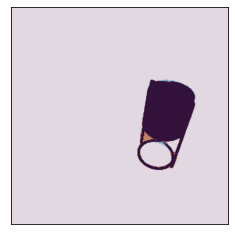

In [77]:
tdw_dataset.is_test = False
metrics = plot_errormap(net, tdw_dataset, ex=41, thresh=4, iters=24)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


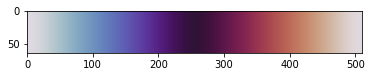

In [275]:
cmap = plt.cm.twilight(range(510))
cmap = np.stack([cmap]*64, 0)
plt.imshow(cmap)

In [67]:
bootraft.layers.num_parameters(net.module.update_block)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3120960

In [68]:
print(net.module.update_block)

BasicUpdateBlock(
  (encoder): BasicMotionEncoder(
    (convc1): Conv2d(324, 256, kernel_size=(1, 1), stride=(1, 1))
    (convc2): Conv2d(256, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (convf1): Conv2d(2, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (convf2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv): Conv2d(256, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (gru): SepConvGRU(
    (convz1): Conv2d(384, 128, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2))
    (convr1): Conv2d(384, 128, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2))
    (convq1): Conv2d(384, 128, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2))
    (convz2): Conv2d(384, 128, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    (convr2): Conv2d(384, 128, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    (convq2): Conv2d(384, 128, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
  )
  (flow_head): FlowHead(
    (conv1): C

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [120]:
tdw_dataset = raft_datasets.TdwFlowDataset(
    root='/data5/dbear/tdw_datasets/playroom_large_v3copy/',
    dataset_names=['model_split_4'],    
    split='training',
    filepattern="*",
    test_filepattern="0*[0-4]",
    min_start_frame=0,
    max_start_frame=None,
    scale_to_pixels=True,
    get_gt_flow=True,
    training_frames='../datasets/supervision_frames/model_split_4_threshargmax.json',
    testing_frames='../datasets/supervision_frames/model_split_4_threshargmax.json'
)
print(len(tdw_dataset))
print(tdw_dataset.is_test)

1250
False


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [111]:
list(tdw_dataset.training_frames.values())[:10]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[4], [9], [14], [21], [11], [4], [48], [15], [11], [52]]

In [112]:
list(tdw_dataset.testing_frames.values())[:10]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[4], [9], [14], [21], [11], [44], [7], [14], [119], [6]]

In [122]:
data_blob = tdw_dataset[5]

selected frame 4


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [184]:
torch.randint?

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [191]:
x = torch.rand([4, 8, 64]).transpose(1,2)
inds = torch.randint(low=0, high=64, size=[4,6], dtype=torch.long)
b_inds = torch.arange(4, dtype=torch.long)[:,None].repeat(1,6)
inds = torch.stack([b_inds, inds])
x[list(inds)].shape

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


torch.Size([4, 6, 8])

In [227]:
import kmeans
Knet = kmeans.KMeans(num_clusters=32, num_iters=50, append_coordinates=True).cuda()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [228]:
img1, img2, flow, _ = tdw_dataset[3]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [229]:
img = img1[None].to(torch.uint8).cuda()
labels = Knet(img)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


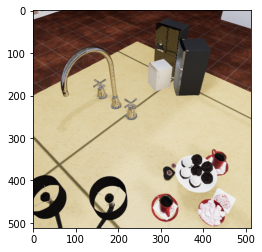

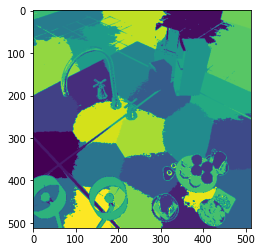

In [230]:
viz(img)
plt.show()
viz(labels)
plt.show()

In [18]:
import compute_training_frames as filtering
knet = torch.nn.DataParallel(filtering.KMeans(16, 50, True)).cuda()
seg_net = filtering.VideoSegmentationModel(model=knet, num_input_frames=1).cuda()
motion_net = net
explain_net = filtering.ExplainedAwayMotion(motion_net, seg_net)

def viz_segments(net, dataset, ex=0, iters=12, test_mode=True):
    img1, img2 = dataset[ex][:2]
    score = net(img1[None].cuda(), img2[None].cuda(), iters=iters, test_mode=True)
    
    fig, axes = plt.subplots(1,4, figsize=(12,4))
    
    axes[0].imshow((img1 / 255.).permute(1,2,0).numpy())
    axes[1].imshow(net.motion_segments[0].detach().cpu().numpy(), cmap='magma')
    axes[2].imshow(net.static_segments[0].detach().cpu().numpy(), cmap='plasma')
    axes[3].imshow(net.out_segments[0].detach().cpu().numpy(), cmap='YlGnBu')
    
    titles = ['Image1', 'MotionSeg', 'StaticSegs', 'FinalSegs']
    for i,ax in enumerate(axes):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(titles[i], fontsize=20)
        
    plt.tight_layout()
    plt.show()
    
    return score


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


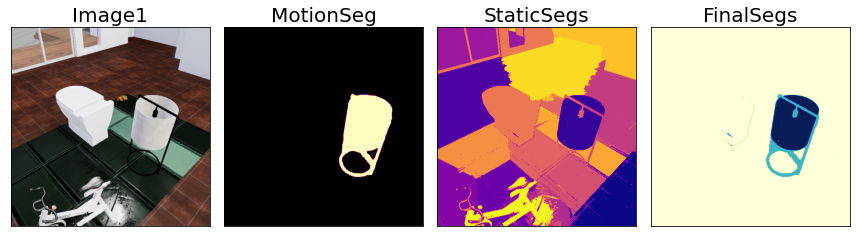

0.020595550537109375

In [19]:
viz_segments(explain_net, tdw_dataset, ex=41)

# read in robonet

In [20]:
import dorsalventral.data.robonet as robonet
import dorsalventral.vis_utils as vis_utils

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
robonet.get_robot_names()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['berkeley_sawyer',
 'berkeley_widowx',
 'google',
 'meta_data.pkl',
 'penn_baxter_left',
 'penn_baxter_right',
 'penn_kuka',
 'stanford_fetch',
 'stanford_franka',
 'stanford_franka_corr_noise']

In [339]:
robonet_dataset = robonet.RobonetDataset(sequence_length=2)

Using 700 files from robots with names ['berkeley_sawyer', 'berkeley_widowx', 'google', 'penn_baxter_left', 'penn_baxter_right', 'penn_kuka', 'stanford_fetch', 'stanford_franka', 'stanford_franka_corr_noise']


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [342]:
rmov = robonet_dataset[0]

filename: /data5/dbear/robonet_sampler/hdf5/berkeley_sawyer_traj11308.hdf5
num_states --> 31
arr shape (2, 240, 320, 3)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


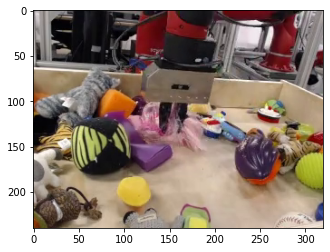

In [352]:
vis_utils.imshow(rmov['images'], None, 1)

In [50]:
robonet_dataset = raft_datasets.RobonetFlowDataset(sequence_length=2, 
                                                   dataset_names=["berk*"],
                                                   train=False
                                                  )
print(robonet_dataset.all_robots)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Using 200 files from robots with names ['berk*']
['berkeley_sawyer', 'berkeley_widowx', 'google', 'meta_data.pkl', 'penn_baxter_left', 'penn_baxter_right', 'penn_kuka', 'stanford_fetch', 'stanford_franka', 'stanford_franka_corr_noise']


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


filename: /data5/dbear/robonet_sampler/hdf5/berkeley_sawyer_traj19970.hdf5
num_states --> 31
arr shape (2, 240, 320, 3)


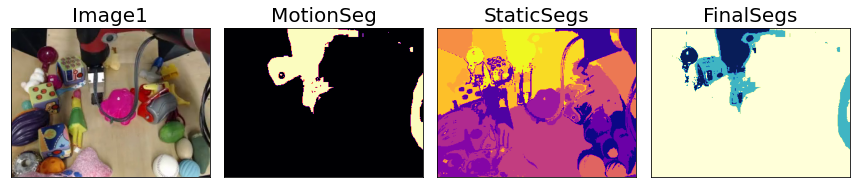

0.07240885496139526

In [23]:
viz_segments(explain_net, robonet_dataset, 15)

In [ ]:
net = nn.DataParallel()

In [51]:
load_path = '../models/raft-sintel.pth'
# load_path = '../checkpoints/raft-tdw-bn-fullplay.pth'
net.load_state_dict(torch.load(load_path), strict=False)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<All keys matched successfully>

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


../models/raft-sintel.pth
arr shape (2, 240, 320, 3)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


arr shape (2, 240, 320, 3)
arr shape (2, 240, 320, 3)
arr shape (2, 240, 320, 3)
arr shape (2, 240, 320, 3)


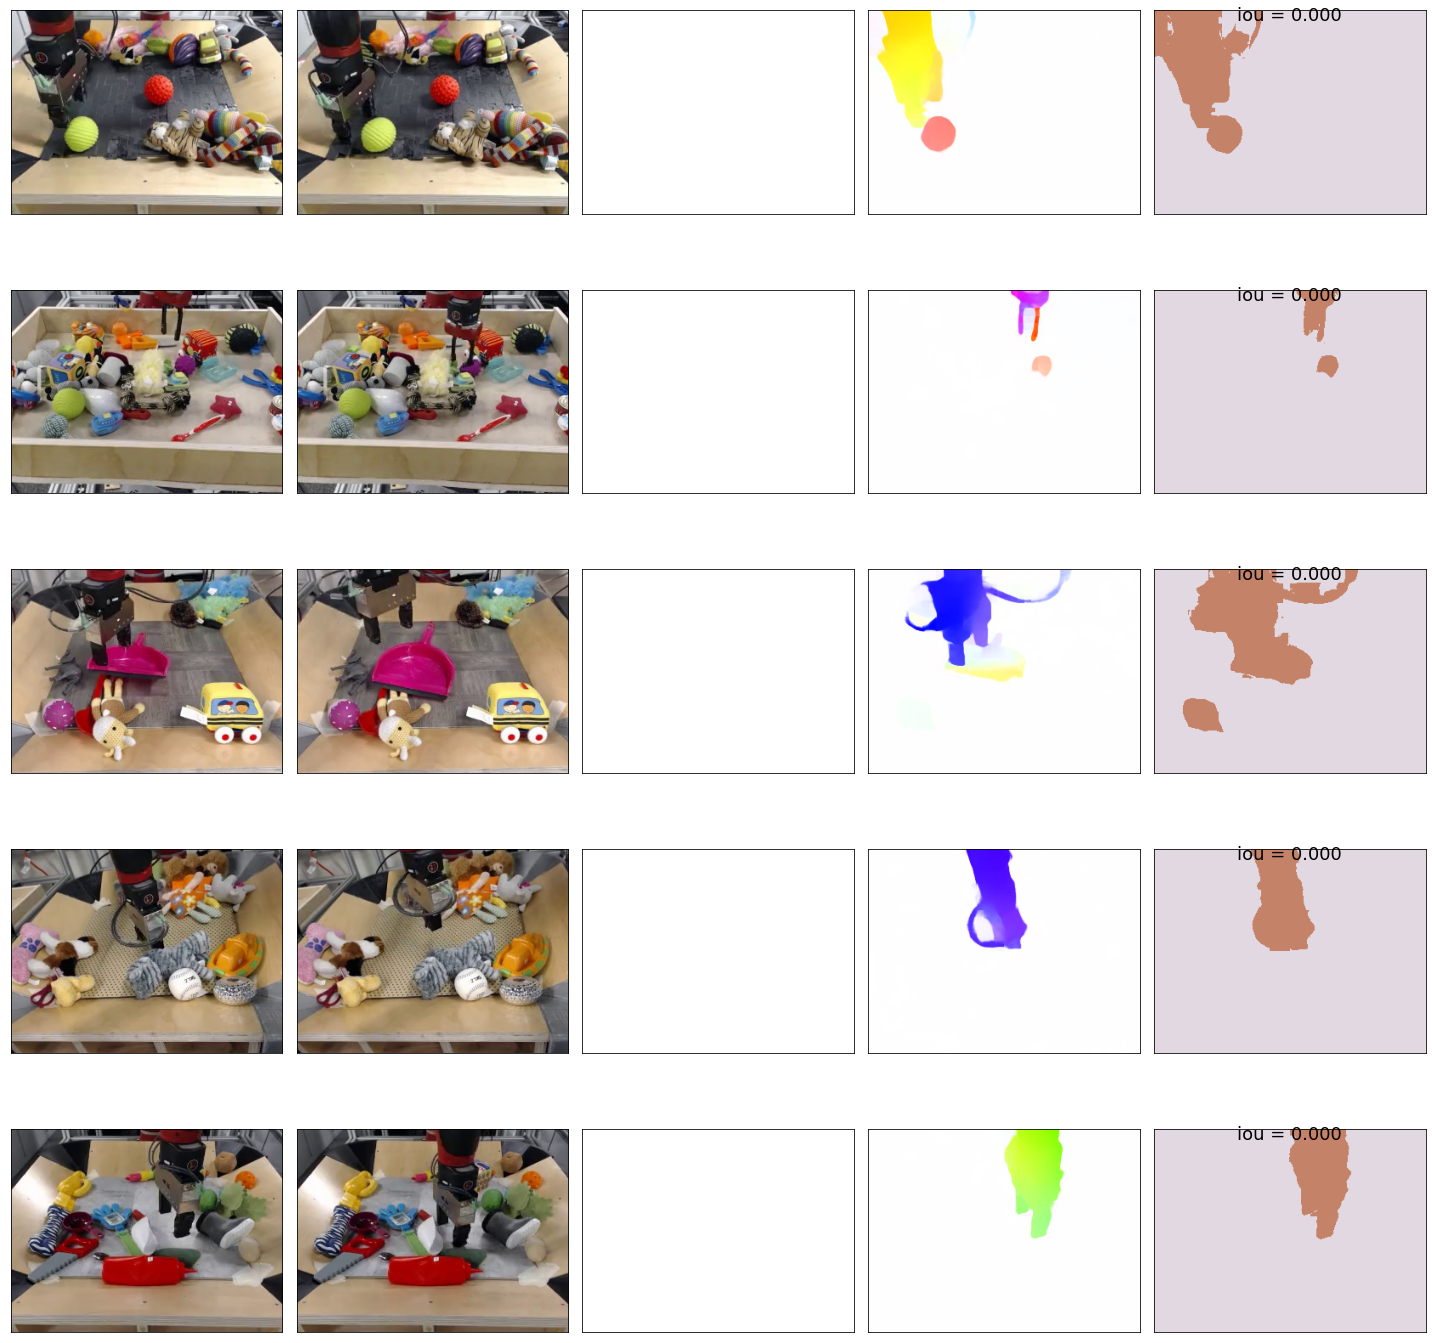

In [52]:
print(load_path)
visualize_error_maps(net, robonet_dataset, examples=range(5,10), thresh=0.5)